In [0]:
!pip install category_encoders 
!pip install mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from google.colab import files

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from google.colab import drive
drive.mount('/content/drive')


root_path = 'content/drive/My Drive/Colab Notebooks'

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link="https://drive.google.com/open?id=1yWILJbdjbRwoRvlQ9e91QrMdqLGsuBmb"

fluff, id = link.split('=')
print (id)

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('opendata_tess_ow.csv')  
df3 = pd.read_csv('opendata_tess_ow.csv')

#data has been loaded to data frame df3 and copy is made to h

h = df3.copy()
#data cleanup
h['FAMILY_SIZE'] = np.where(h['FAMILY_SIZE'] =='4+',h['FAMILY_SIZE'],
                            np.where(h['FAMILY_SIZE'] =='4',h['FAMILY_SIZE'],
                                     np.where(h['FAMILY_SIZE'] =='3',h['FAMILY_SIZE'],
                                              np.where(h['FAMILY_SIZE'] =='2',h['FAMILY_SIZE'],'1'))))
#rename columns
h.rename(columns = {'OFF':'OFFICE','CASES                                    ':'CASES'}, inplace = True)
#drop columns not required for analysis
h.drop(["YEAR_NUM","MNTH","PROGRAM_NM","EARNINGS","WARD_SCODE","CENSUS_NEIGH_SCODE","EDUCATION_LEVEL","FAMILY_TYP_NM","YOUNGEST_DEP_AGE_RANGE","MONTHS_ON_ASSISTANCE",],axis =1 , inplace =True)
#Features selected from principal component analysis are retained and others are dropped.aggregate the total cases, exits and new cases at the below level
h_agg=h.groupby([ 'OFFICE',  'FAMILY_SIZE', 'AGE', 'IMMIGRATION_STATUS', 'TIMES_ON_ASSISTANCE', 'MONTHS_OFF_ASSISTANCE','SHELTER_COSTS','GENDER'], as_index= False).sum()

#Features are decided. Calculate the outcome variable EXIT_BINARY based on the sum of EXITS for the population
h_agg['EXIT_BINARY'] = np.where(h_agg['EXITS']==0,0 ,1)
h_agg.drop(["NEW_CASES","EXITS","CASES",],axis =1 , inplace =True)







Features are decided.Outcome variable(EXIT_BINARY) is calculated.Other unwanted columns are dropped.
Checked for imbalance in class variable. It is  balanced.

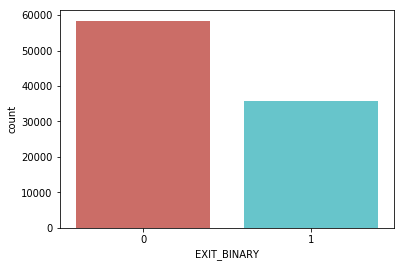

In [11]:
sns.countplot(x='EXIT_BINARY',data=h_agg, palette='hls')
plt.show()


There are two classes :

Outcome : EXIT_BINARY = 1 or Y. Population has EXITS > 0. 

Outcome : EXIT_BINARY = 0 or N. Population has EXITS = 0. Never exited Ontario Works.

Create two different dataframe for the different values of class variable

In [0]:
Out_N = h_agg[h_agg['EXIT_BINARY']==0]
Out_Y = h_agg[h_agg['EXIT_BINARY']!=0]



The features are all categorical variables.So, one hot encoding is done for both dataframes: Outcome = Y (Out_Y)
Outcome = N (Out_N)

In [0]:
#For Outcome = Y or EXIT_BINARY = 1 

ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
Out_Y_ohe = ohe.fit_transform(Out_Y)
Out_Y_ohe.drop(["EXIT_BINARY",],axis =1 , inplace =True)

#For Outcome = N or EXIT_BINARY = 0 

ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
Out_N_ohe = ohe.fit_transform(Out_N)
#Out_N_ohe.drop(["EXIT_BINARY",],axis =1 , inplace =True)


For Outcome = N, EXIT_BINARY=0, Population has never exited OW  program

Running Apriori association mining with 3 different support and confidence values.

In [0]:

#Apriori for EXIT BINARY = 0
#Since data is filtered only for EXIT_BINARY = 0 => Support(EXIT_BINARY is 0, No exits) = 1 always.
# Confidence Confidence (EXIT_BINARY is 0 -> Any feature of population) = Support (feature of population, EXIT_BINARY=0)/1 = Support (feature of population)

# Support and Confidence have the same values
# Cannot run multiple iterations with different support in this case

#Support = 0.25 ; Confidence = 0.25

frequent_itemsets_0_1 = apriori(Out_N_ohe, min_support=0.25, use_colnames=True)
print(frequent_itemsets_0_1)

